In [1]:
import gately
import shapley
import numpy as np
import random
import timeit
import shap

In [2]:
X, y = shap.datasets.boston()
X = X.values

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datase

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

regr = xgboost.XGBRegressor().fit(X_train, y_train)
regr.fit(X_train, y_train)
regr.score(X_test,y_test)

0.886203277377512

In [4]:
datas = []
for i in range(1000):
    data = []
    pop = random.uniform(-1,1)
    data.append(pop)
    data.append(pop*0.2)
    data.append(pop*0.6)
    data.append(pop*2)
    data.append(pop*5)
    for i in range(0,2):
        data.append(random.uniform(-1,1))
    datas.append(data)
datas = np.asarray(datas)

In [5]:
def f_simple(x):
    # Complex coincedation of the Shapley value and the Gately Point 
    return x[:,0] + 2*(x[:,2]) + 0.8*x[:,1] - 0.5*(x[:,3]) + 0.2*x[:,4] + 2*(x[:,4]) + 3*x[:,5] +6*(x[:,6])

In [6]:
att_shap, dist_shap = shapley.shapley_int_distribution(f_simple,datas[0],datas[1])

In [7]:
att_shap

{0: array([-0.62560519]),
 1: array([-0.10009683]),
 2: array([-0.75072623]),
 3: array([0.62560519]),
 4: array([-6.88165712]),
 5: array([-0.45858968]),
 6: array([6.81254463])}

In [8]:
att_gately, dist_gately = gately.Gately_distribution(datas[0],datas[1],f_simple)

In [9]:
att_gately

{0: array([-0.62560519]),
 1: array([-0.10009683]),
 2: array([-0.75072623]),
 3: array([0.62560519]),
 4: array([-6.88165712]),
 5: array([-0.45858968]),
 6: array([6.81254463])}

In [10]:
matches = 0
distributions_shap = []
distributions_gately = []
for ind in range(0,20):
    att_shap, dist_shap = shapley.shapley_int_distribution(f_simple,datas[ind],datas[ind+1])
    att_gately, dist_gately = gately.Gately_distribution(datas[ind],datas[ind+1],f_simple)

    tick = 0
    for i,j in zip(att_shap.values(),att_gately.values()):
        if round(i[0],2) != round(j[0],2):
            tick = 1
    if tick == 0:
        matches += 1
    
    distributions_shap.append(dist_shap)
    distributions_gately.append(dist_gately)
        
distributions_shap = np.asarray(distributions_shap)
distributions_gately = np.asarray(distributions_gately)
distributions_shap = distributions_shap.reshape(-1,distributions_shap.shape[2])
distributions_gately = distributions_gately.reshape(-1,distributions_gately.shape[2])

In [11]:
print(matches/20)

1.0


In [12]:
scores_gately = []
scores_shap = []

for i in range(1,100):
    new_X = np.concatenate([distributions_gately[0:200],datas[0:200]])
    new_Y = np.concatenate([np.zeros(200),np.ones(200)])
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(new_X, new_Y, test_size=0.5)

    regr = RandomForestClassifier(n_estimators=i, random_state=0)
    regr.fit(X_train, y_train)
    scores_gately.append(regr.score(X_test,y_test))

    new_X = np.concatenate([distributions_shap[0:200],datas[0:200]])
    new_Y = np.concatenate([np.zeros(200),np.ones(200)])

    X_train, X_test, y_train, y_test = train_test_split(new_X, new_Y, test_size=0.5)

    regr = RandomForestClassifier(n_estimators=i, random_state=0)
    regr.fit(X_train, y_train)
    scores_shap.append(regr.score(X_test,y_test))


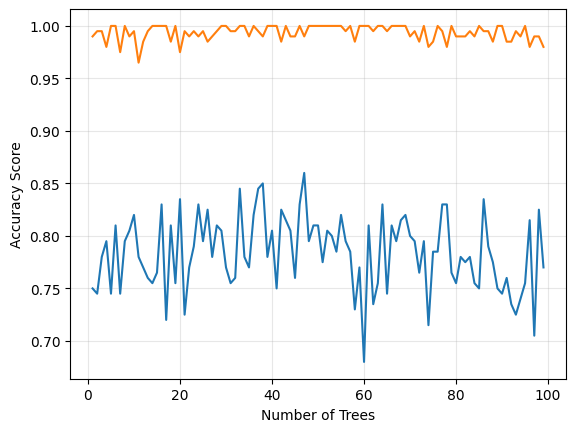

In [13]:
import matplotlib.pyplot as plt

depth = np.arange(1,100)
plt.plot(depth, scores_gately)
plt.plot(depth, scores_shap)
plt.ylabel('Accuracy Score')
plt.xlabel('Number of Trees')
plt.grid(alpha=0.3)
plt.savefig('distribution_synthetic.pdf')

In [14]:
X = np.concatenate([distributions_shap[0:140],datas[0:140]])
Y = np.concatenate([np.zeros(140),np.ones(140)])
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

regr = RandomForestClassifier(max_depth=1, random_state=0)
regr.fit(X_train, y_train)
regr.score(X_test,y_test)

1.0